In [21]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error,median_absolute_error,r2_score
from datetime import datetime

import plotnine
from plotnine import ggplot, aes, geom_line, scale_x_datetime, geom_point, xlab, ylab
from plotnine.scales.scale_color import scale_color_hue
from plotnine.facets.facet_grid import facet_grid
from keras.models import Sequential
from keras.layers import Dense,LSTM
from sklearn.preprocessing import MinMaxScaler

In [22]:
df = pd.read_csv("cpu_mem_req_lat_211022_190123.csv")
df.head(5)

,Date,Process CPU usage,Process memory usage,Request count,Reponse time
0,2022-10-21 12:00,3.83,6.26,316000.0,0.198
1,2022-10-21 13:00,5.01,6.27,436000.0,0.252
2,2022-10-21 14:00,4.38,6.29,376000.0,0.230
3,2022-10-21 15:00,4.34,6.29,378000.0,0.200
4,2022-10-21 16:00,3.77,6.30,312000.0,0.191


In [23]:
df.dropna(inplace=True)
df.columns = ['timestamp', 'cpu', 'memory', 'request', 'latency']
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M'))
df

,timestamp,cpu,memory,request,latency
0,2022-10-21 12:00:00,3.83,6.26,316000.0,0.198
1,2022-10-21 13:00:00,5.01,6.27,436000.0,0.252
2,2022-10-21 14:00:00,4.38,6.29,376000.0,0.230
3,2022-10-21 15:00:00,4.34,6.29,378000.0,0.200
4,2022-10-21 16:00:00,3.77,6.30,312000.0,0.191
...,...,...,...,...,...
2156,2023-01-19 08:00:00,1.27,3.26,204000.0,0.157
2157,2023-01-19 09:00:00,1.35,3.26,211000.0,0.153
2158,2023-01-19 10:00:00,1.44,3.27,235000.0,0.141
2159,2023-01-19 11:00:00,2.23,3.27,644000.0,0.104


In [24]:
plotnine.options.figure_size = (23, 4.8)

def plot_data(data, metric):
  return ggplot(data) + aes(x='timestamp', y=metric) + geom_line() + scale_x_datetime()

In [25]:
def prediction(df, metrics, epochs):
 
  #normalize
  df.timestamp = list(range(df.shape[0]))
  df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

  df.dropna(inplace=True)

  #extract only the closing data
  data = df.filter([metrics])
  dataset = data.values
  
  #separates 80% of this data
  training_data_len = math.floor(len(dataset)*.8)

  #scaling to the range between 0 and 1
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(dataset)

  #creating a training dataset
  train_data = scaled_data[0:training_data_len,:]
  
  #separating training and testing data
  x_train=[]
  y_train=[]

  for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

  #converting x_train and y_train to a numpy array
  x_train,y_train = np.array(x_train), np.array(y_train)

  #data resizing
  x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

  #creating the test base
  test_data=scaled_data[training_data_len-60:,:]

  #creating x_test and y_test
  x_test=[]
  y_test=dataset[training_data_len:,:]

  for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

  x_test=np.array(x_test)
  x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

  #creating the model
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
  model.add(LSTM(50, return_sequences=True))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  #compiling the model
  model.compile(optimizer='adam', loss='mse')

  #training the model
  model.fit(x_train, y_train, batch_size=100,epochs=epochs, validation_data=(x_test, y_test))

  #generating the forecasts
  predictions = model.predict(x_test)
 
  #reversing the scale
  predictions = scaler.inverse_transform(predictions)

  #generating the results
  dfp = pd.DataFrame()
  valid=data[training_data_len:]
  valid[metrics] = predictions
  dfp[metrics]=valid[metrics]

  return dfp, predictions, y_test

##CPU

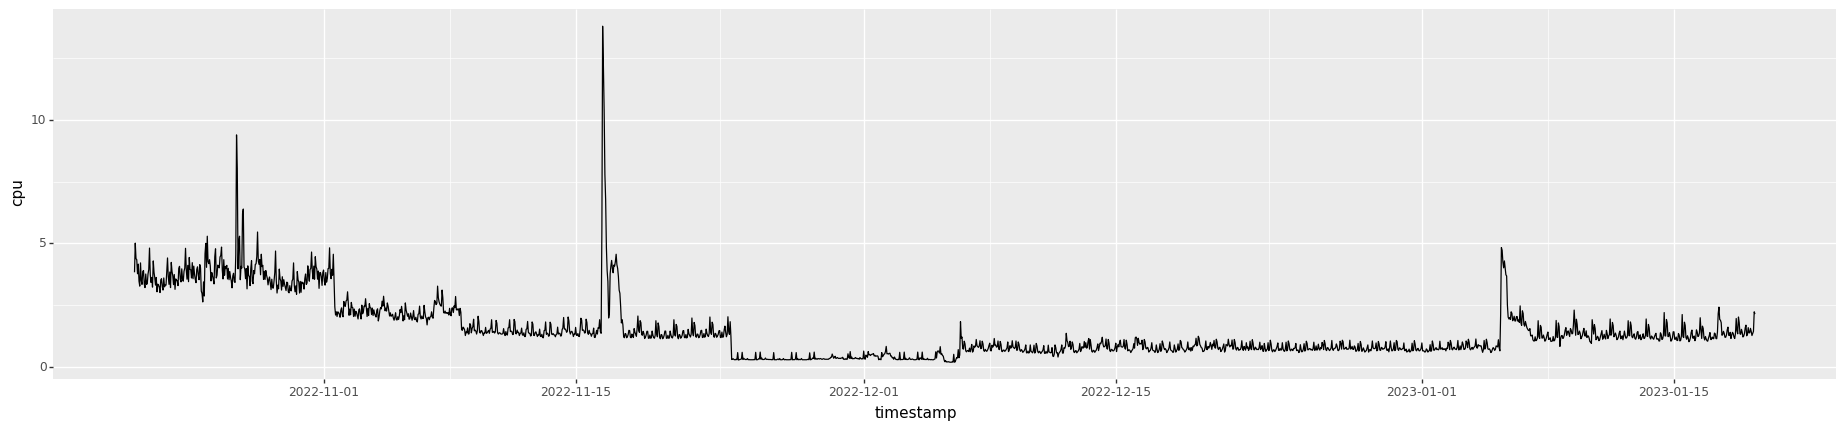

In [26]:
print(plot_data(df, 'cpu'))

In [27]:
start_cpu = time.time()

In [28]:
df_pred_cpu, predictions_cpu, test_cpu = prediction(df, 'cpu', 100)

Epoch 1/100
17/17 [==============================] - 11s 300ms/step - loss: 0.0051 - val_loss: 1.7735
Epoch 2/100
17/17 [==============================] - 3s 155ms/step - loss: 0.0025 - val_loss: 1.7932
Epoch 3/100
17/17 [==============================] - 3s 153ms/step - loss: 0.0022 - val_loss: 1.8218
Epoch 4/100
17/17 [==============================] - 3s 157ms/step - loss: 0.0022 - val_loss: 1.7992
Epoch 5/100
17/17 [==============================] - 4s 215ms/step - loss: 0.0022 - val_loss: 1.8051
Epoch 6/100
17/17 [==============================] - 3s 156ms/step - loss: 0.0022 - val_loss: 1.8238
Epoch 7/100
17/17 [==============================] - 3s 154ms/step - loss: 0.0021 - val_loss: 1.8167
Epoch 8/100
17/17 [==============================] - 3s 154ms/step - loss: 0.0021 - val_loss: 1.7949
Epoch 9/100
17/17 [==============================] - 4s 212ms/step - loss: 0.0021 - val_loss: 1.7872
Epoch 10/100
17/17 [==============================] - 3s 164ms/step - loss: 0.0020 - val_l

<ipython-input-25-e7208f363bb5>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
end_cpu = time.time()

In [30]:
print('Erro médio absoluto :', mean_absolute_error(predictions_cpu,test_cpu))
print('Erro médio quadrado :', mean_squared_error(predictions_cpu,test_cpu))
print('Coeficiente de determinação (R²):', r2_score(predictions_cpu,test_cpu))
print("Tempo de execução:", end_cpu-start_cpu)

Erro médio absoluto : 0.17883999754044533
Erro médio quadrado : 0.08706635224590822
Coeficiente de determinação (R²): 0.6527797833127766
Tempo de execução: 297.990327835083


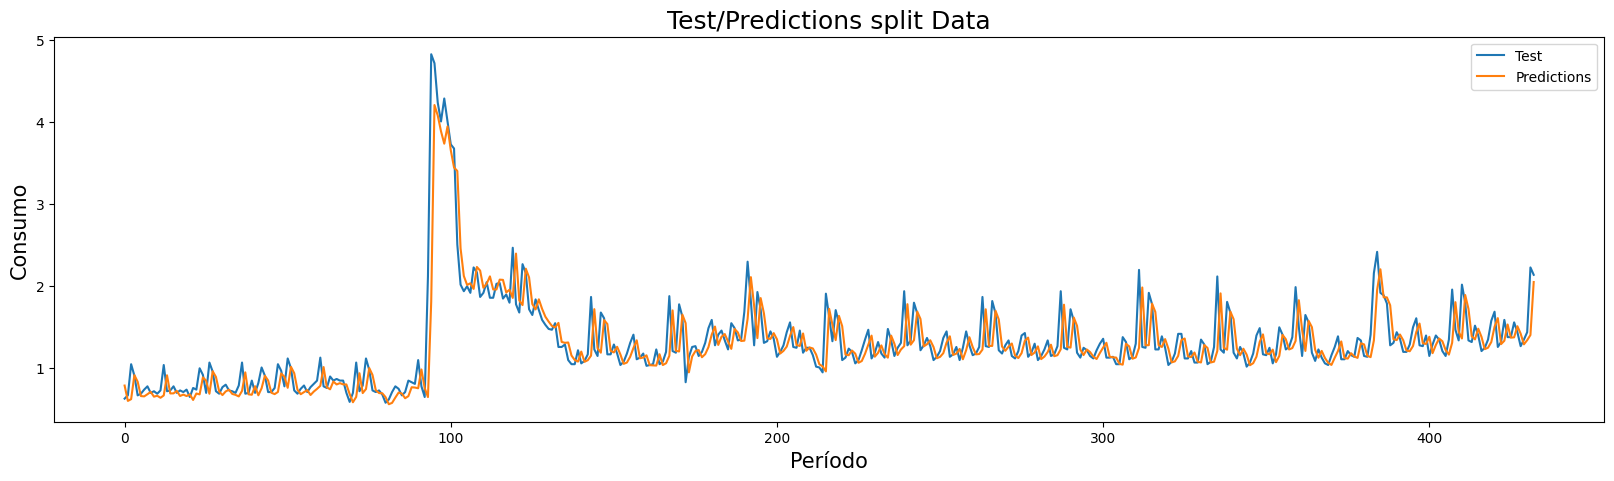

In [31]:
plt.figure(figsize=(20,5))
plt.xlabel('Período',size=15)
plt.ylabel('Consumo',size=15)
plt.plot(test_cpu)
plt.plot(predictions_cpu)
plt.title("Test/Predictions split Data", size=18)
plt.legend(['Test','Predictions'])
plt.show()

##MEMORY

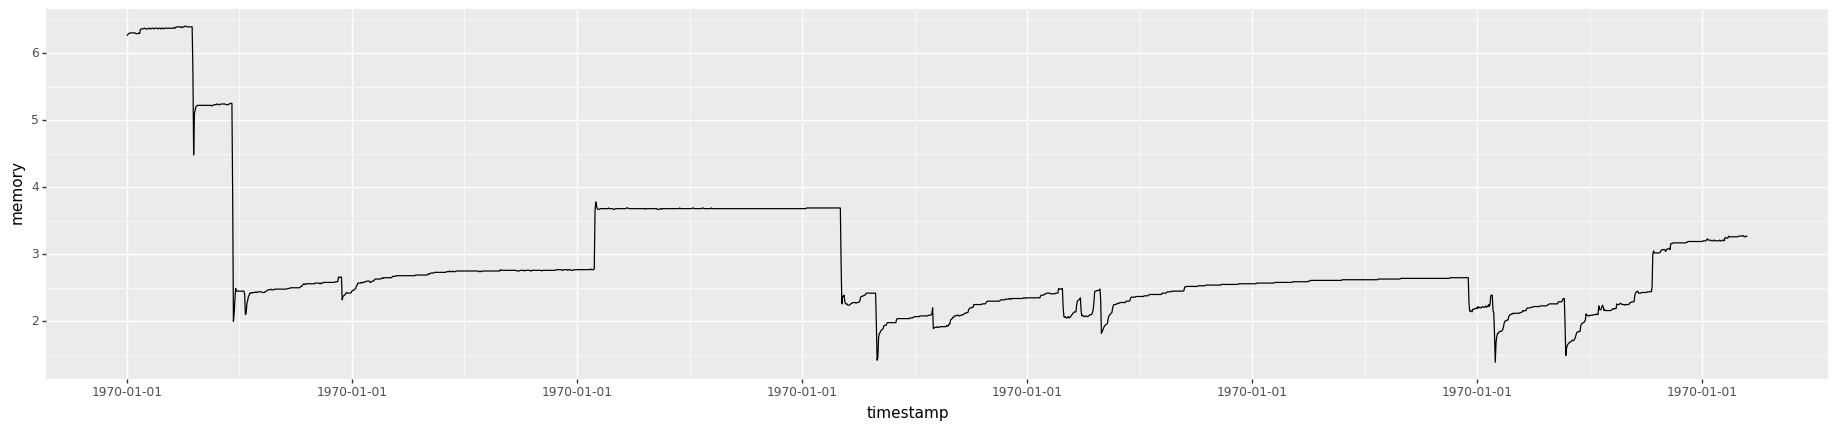

In [32]:
print(plot_data(df, 'memory'))

In [33]:
start_memory = time.time()

In [34]:
df_pred_memory, predictions_memory, test_memory = prediction(df, 'memory', 100)

Epoch 1/100
17/17 [==============================] - 10s 225ms/step - loss: 0.0243 - val_loss: 5.3750
Epoch 2/100
17/17 [==============================] - 3s 154ms/step - loss: 0.0053 - val_loss: 5.4274
Epoch 3/100
17/17 [==============================] - 3s 153ms/step - loss: 0.0031 - val_loss: 5.4164
Epoch 4/100
17/17 [==============================] - 4s 223ms/step - loss: 0.0027 - val_loss: 5.4218
Epoch 5/100
17/17 [==============================] - 3s 154ms/step - loss: 0.0025 - val_loss: 5.4264
Epoch 6/100
17/17 [==============================] - 3s 151ms/step - loss: 0.0023 - val_loss: 5.4600
Epoch 7/100
17/17 [==============================] - 3s 152ms/step - loss: 0.0022 - val_loss: 5.4302
Epoch 8/100
17/17 [==============================] - 3s 188ms/step - loss: 0.0020 - val_loss: 5.4696
Epoch 9/100
17/17 [==============================] - 3s 176ms/step - loss: 0.0020 - val_loss: 5.4471
Epoch 10/100
17/17 [==============================] - 3s 154ms/step - loss: 0.0019 - val_l

<ipython-input-25-e7208f363bb5>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
end_memory = time.time()

In [36]:
print('Erro médio absoluto :', mean_absolute_error(predictions_memory,test_memory))
print('Erro médio quadrado :', mean_squared_error(predictions_memory,test_memory))
print('Coeficiente de determinação (R²):', r2_score(predictions_memory,test_memory))
print("Tempo de execução:", end_memory-start_memory)

Erro médio absoluto : 0.028326379696711652
Erro médio quadrado : 0.00600604835182944
Coeficiente de determinação (R²): 0.9733602663514551
Tempo de execução: 330.1974937915802


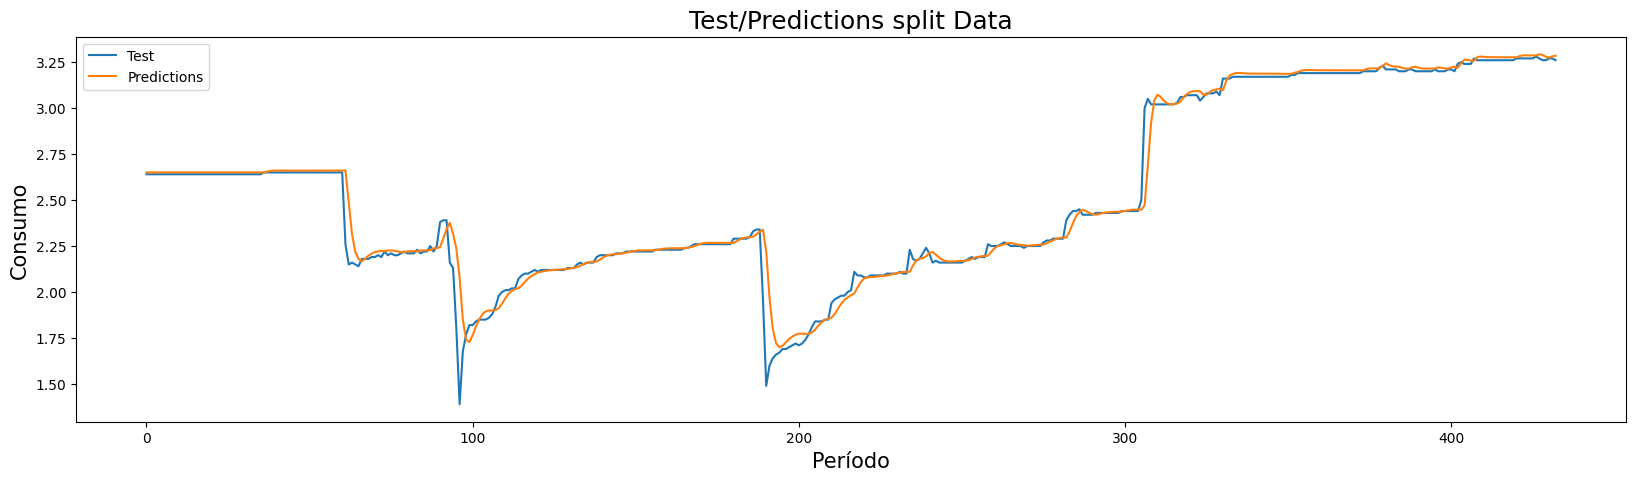

In [37]:
plt.figure(figsize=(20,5))
plt.xlabel('Período',size=15)
plt.ylabel('Consumo',size=15)
plt.plot(test_memory)
plt.plot(predictions_memory)
plt.title("Test/Predictions split Data", size=18)
plt.legend(['Test','Predictions'])
plt.show()

##REQUEST

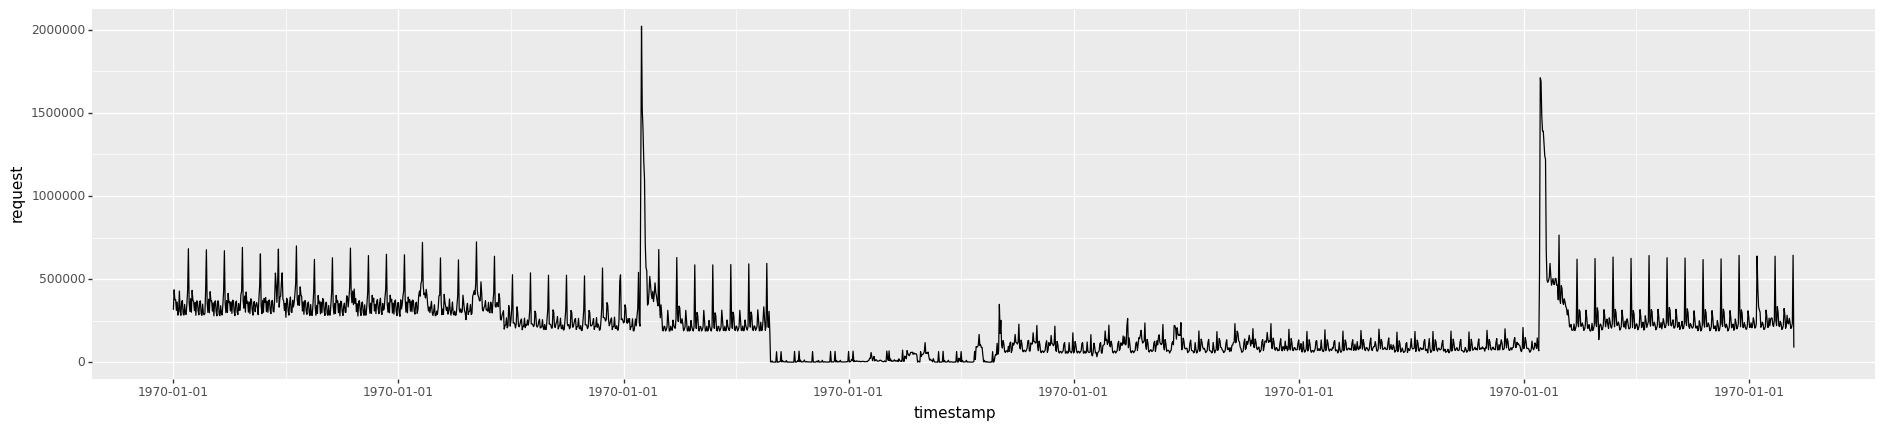

In [38]:
print(plot_data(df, 'request'))

In [39]:
start_request = time.time()

In [40]:
df_pred_request, predictions_request, test_request = prediction(df, 'request', 100)

Epoch 1/100
17/17 [==============================] - 11s 222ms/step - loss: 0.0050 - val_loss: 105998950400.0000
Epoch 2/100
17/17 [==============================] - 3s 152ms/step - loss: 0.0025 - val_loss: 105998966784.0000
Epoch 3/100
17/17 [==============================] - 3s 161ms/step - loss: 0.0023 - val_loss: 105998966784.0000
Epoch 4/100
17/17 [==============================] - 3s 203ms/step - loss: 0.0023 - val_loss: 105998974976.0000
Epoch 5/100
17/17 [==============================] - 3s 151ms/step - loss: 0.0023 - val_loss: 105998950400.0000
Epoch 6/100
17/17 [==============================] - 3s 151ms/step - loss: 0.0022 - val_loss: 105998974976.0000
Epoch 7/100
17/17 [==============================] - 3s 152ms/step - loss: 0.0022 - val_loss: 105998950400.0000
Epoch 8/100
17/17 [==============================] - 3s 205ms/step - loss: 0.0022 - val_loss: 105998950400.0000
Epoch 9/100
17/17 [==============================] - 3s 166ms/step - loss: 0.0022 - val_loss: 105998950

<ipython-input-25-e7208f363bb5>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
end_request = time.time()

In [42]:
print('Erro médio absoluto :', mean_absolute_error(predictions_request,test_request))
print('Erro médio quadrado :', mean_squared_error(predictions_request,test_request))
print('Coeficiente de determinação (R²):', r2_score(predictions_request,test_request))
print("Tempo de execução:", end_request-start_request)

Erro médio absoluto : 53138.65827078522
Erro médio quadrado : 14429597290.762823
Coeficiente de determinação (R²): 0.401308245448865
Tempo de execução: 330.73733401298523


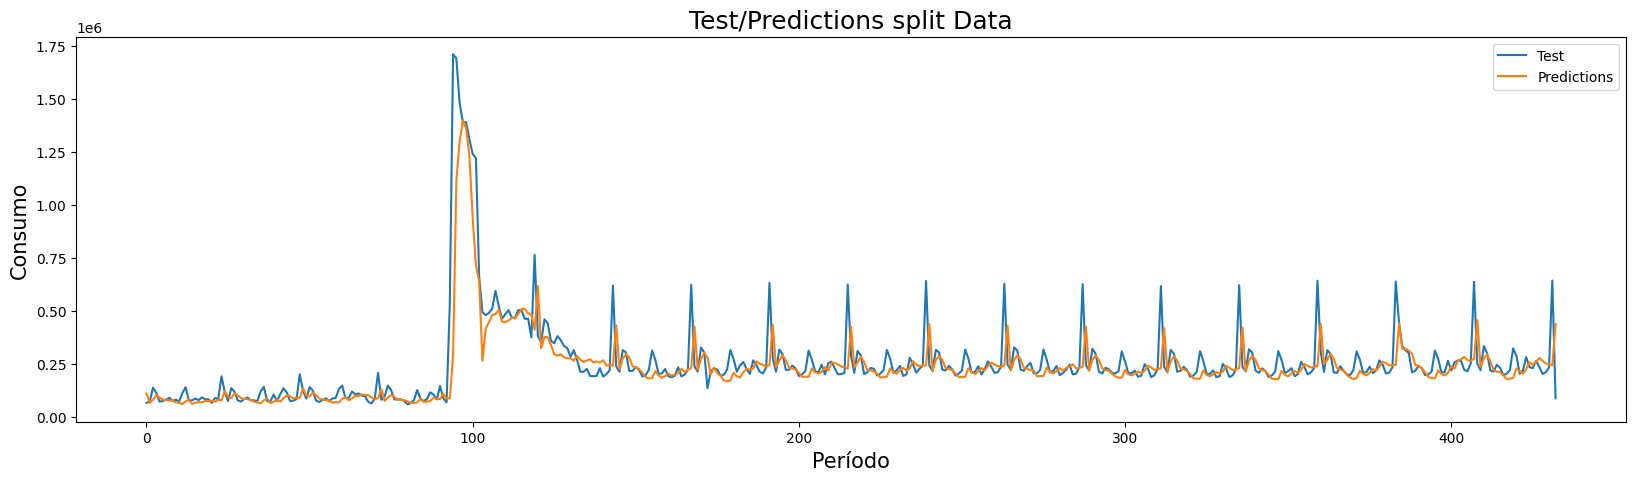

In [43]:
plt.figure(figsize=(20,5))
plt.xlabel('Período',size=15)
plt.ylabel('Consumo',size=15)
plt.plot(test_request)
plt.plot(predictions_request)
plt.title("Test/Predictions split Data", size=18)
plt.legend(['Test','Predictions'])
plt.show()

##LATENCY

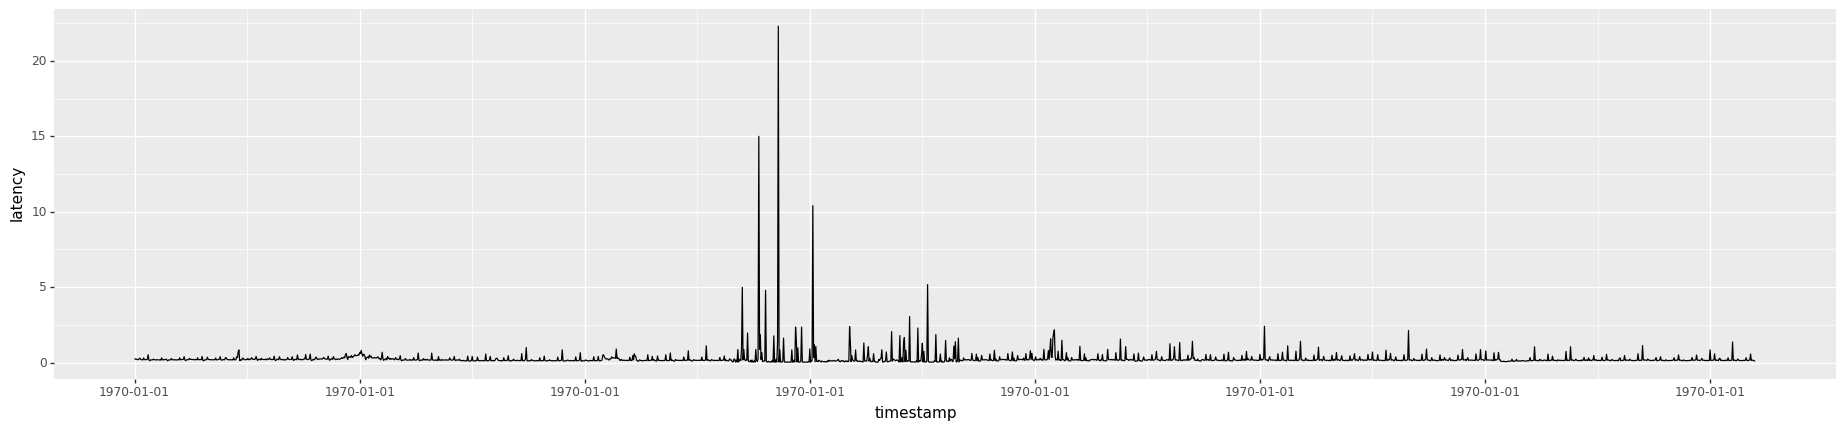

In [44]:
print(plot_data(df, 'latency'))

In [45]:
start_latency = time.time()

In [46]:
df_pred_latency, predictions_latency, test_latency = prediction(df, 'latency', 100)

Epoch 1/100
17/17 [==============================] - 10s 227ms/step - loss: 0.0012 - val_loss: 0.0538
Epoch 2/100
17/17 [==============================] - 3s 155ms/step - loss: 0.0012 - val_loss: 0.0485
Epoch 3/100
17/17 [==============================] - 3s 167ms/step - loss: 0.0012 - val_loss: 0.0519
Epoch 4/100
17/17 [==============================] - 3s 203ms/step - loss: 0.0012 - val_loss: 0.0514
Epoch 5/100
17/17 [==============================] - 3s 154ms/step - loss: 0.0012 - val_loss: 0.0499
Epoch 6/100
17/17 [==============================] - 3s 155ms/step - loss: 0.0012 - val_loss: 0.0490
Epoch 7/100
17/17 [==============================] - 3s 153ms/step - loss: 0.0012 - val_loss: 0.0509
Epoch 8/100
17/17 [==============================] - 4s 225ms/step - loss: 0.0012 - val_loss: 0.0512
Epoch 9/100
17/17 [==============================] - 3s 156ms/step - loss: 0.0012 - val_loss: 0.0525
Epoch 10/100
17/17 [==============================] - 3s 153ms/step - loss: 0.0012 - val_l

<ipython-input-25-e7208f363bb5>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
end_latency = time.time()

In [48]:
print('Erro médio absoluto :', mean_absolute_error(predictions_latency,test_latency))
print('Erro médio quadrado :', mean_squared_error(predictions_latency,test_latency))
print('Coeficiente de determinação (R²):', r2_score(predictions_latency,test_latency))
print("Tempo de execução:", end_latency-start_latency)

Erro médio absoluto : 0.07307735625714684
Erro médio quadrado : 0.020138174292988267
Coeficiente de determinação (R²): -14.46737949914457
Tempo de execução: 298.79026675224304


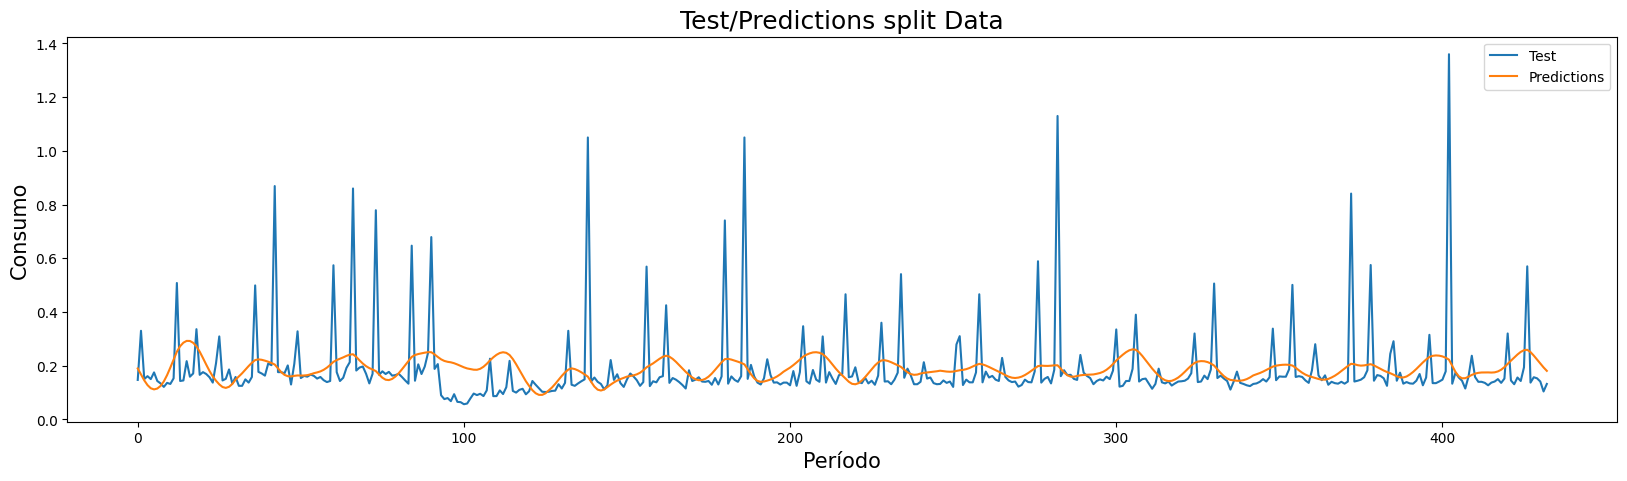

In [49]:
plt.figure(figsize=(20,5))
plt.xlabel('Período',size=15)
plt.ylabel('Consumo',size=15)
plt.plot(test_latency)
plt.plot(predictions_latency)
plt.title("Test/Predictions split Data", size=18)
plt.legend(['Test','Predictions'])
plt.show()